In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/rice leaf diseases dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/rice leaf diseases dataset/Brownspot/BROWNSPOT2_153.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT7_100.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT5_190.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT7_156.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT1_056.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT5_045.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT6_010.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT5_120.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT4_065.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT7_123.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT1_161.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT1_137.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT4_105.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT7_026.jpg
/content/rice leaf diseases dataset/Brownspot/BROWNSPOT6_048.jpg
/content/rice leaf diseas

In [ ]:
pip install split-folders

In [ ]:
import os
import shutil
import splitfolders
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [ ]:
# import shutil
# import os

# bad_folder_train = "/kaggle/working/rice_split/train/rice leaf diseases dataset"
# bad_folder_val = "/kaggle/working/rice_split/val/rice leaf diseases dataset"

# # Remove if they exist
# if os.path.exists(bad_folder_train):
#     shutil.rmtree(bad_folder_train)
# if os.path.exists(bad_folder_val):
#     shutil.rmtree(bad_folder_val)

# print("✅ Cleaned up bad class folder.")


In [ ]:
# Step 1: Copy the dataset to a working directory
src_path = "/content/rice leaf diseases dataset"
dst_path = "/kaggle/working/rice_diseases_dataset"

if os.path.exists(dst_path):
    shutil.rmtree(dst_path)  # remove if exists to avoid FileExistsError

shutil.copytree(src_path, dst_path)


'/kaggle/working/rice_diseases_dataset'

In [ ]:
splitfolders.ratio(
    dst_path,
    output="/kaggle/working/rice_split",
    seed=1651967,
    ratio=(.8, .2)
)


Copying files: 4684 files [00:01, 2980.92 files/s]


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 normalization
    rotation_range=45,                        # matches PyTorch example
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input   # no augmentations, just normalization
)


train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/rice_split/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    "/kaggle/working/rice_split/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

print(train_generator.class_indices)  # Should now show ONLY 3 classes



Found 3747 images belonging to 3 classes.
Found 937 images belonging to 3 classes.
{'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}


In [ ]:
# Load pretrained base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
print("Classes detected:", train_generator.class_indices)
print("Number of classes:", train_generator.num_classes)


Classes detected: {'Bacterialblight': 0, 'Brownspot': 1, 'Leafsmut': 2}
Number of classes: 3


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_resnet_model.keras",
    monitor='val_accuracy',
    save_best_only=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 516ms/step - accuracy: 0.7599 - loss: 0.6755 - val_accuracy: 0.9349 - val_loss: 0.1611
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 436ms/step - accuracy: 0.9431 - loss: 0.1552 - val_accuracy: 0.9616 - val_loss: 0.0966
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 425ms/step - accuracy: 0.9618 - loss: 0.1039 - val_accuracy: 0.9893 - val_loss: 0.0429
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 417ms/step - accuracy: 0.9775 - loss: 0.0654 - val_accuracy: 0.9723 - val_loss: 0.0597
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 417ms/step - accuracy: 0.9698 - loss: 0.0819 - val_accuracy: 0.9776 - val_loss: 0.0596
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 426ms/step - accuracy: 0.9861 - loss: 0.0507 - val_accuracy: 0.9968 - val_loss: 0.0156
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 81s 420ms/step - accuracy: 0.9842 - loss: 0.0452 - val_accuracy: 0.9968 - val_loss: 0.0187
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 418ms/step - accuracy: 0.9858 - loss: 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


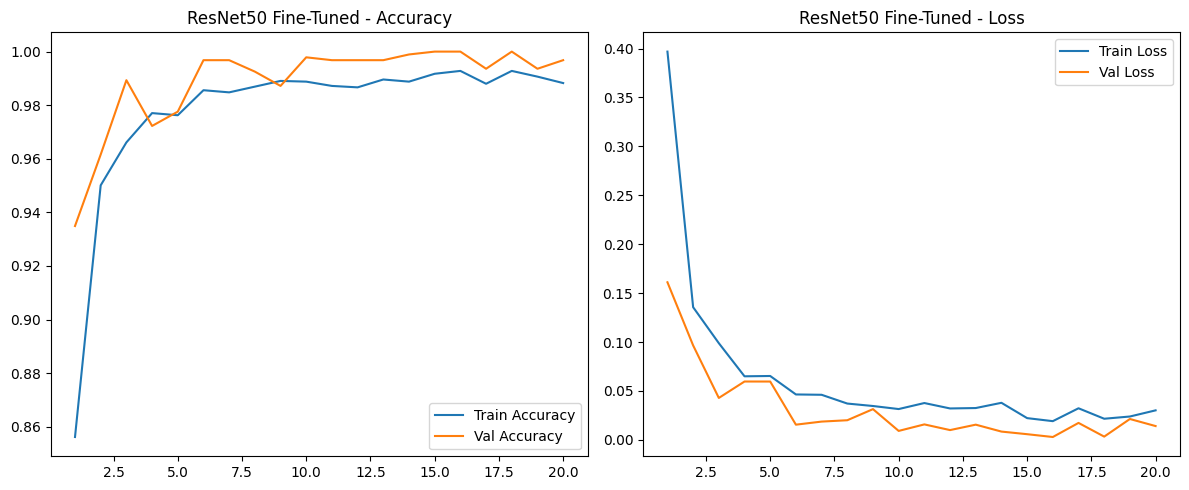

In [ ]:
def plot_learning_curves(history, title="ResNet50 Fine-Tuned"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title(f'{title} - Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend()
    plt.title(f'{title} - Loss')

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)


✅ Best Validation Accuracy: 1.0000
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step


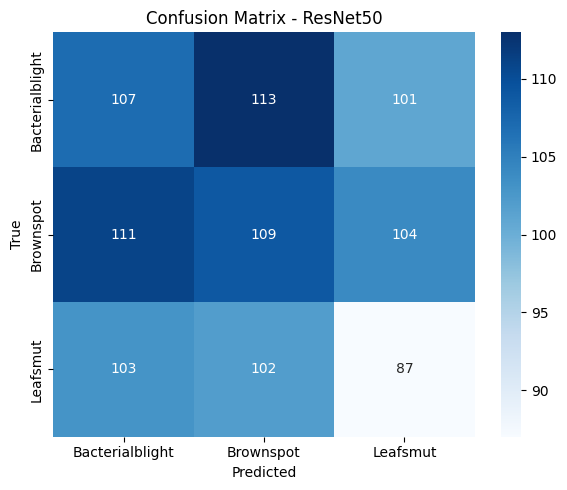

Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.33      0.33      0.33       321
      Brownspot       0.34      0.34      0.34       324
       Leafsmut       0.30      0.30      0.30       292

       accuracy                           0.32       937
      macro avg       0.32      0.32      0.32       937
   weighted avg       0.32      0.32      0.32       937



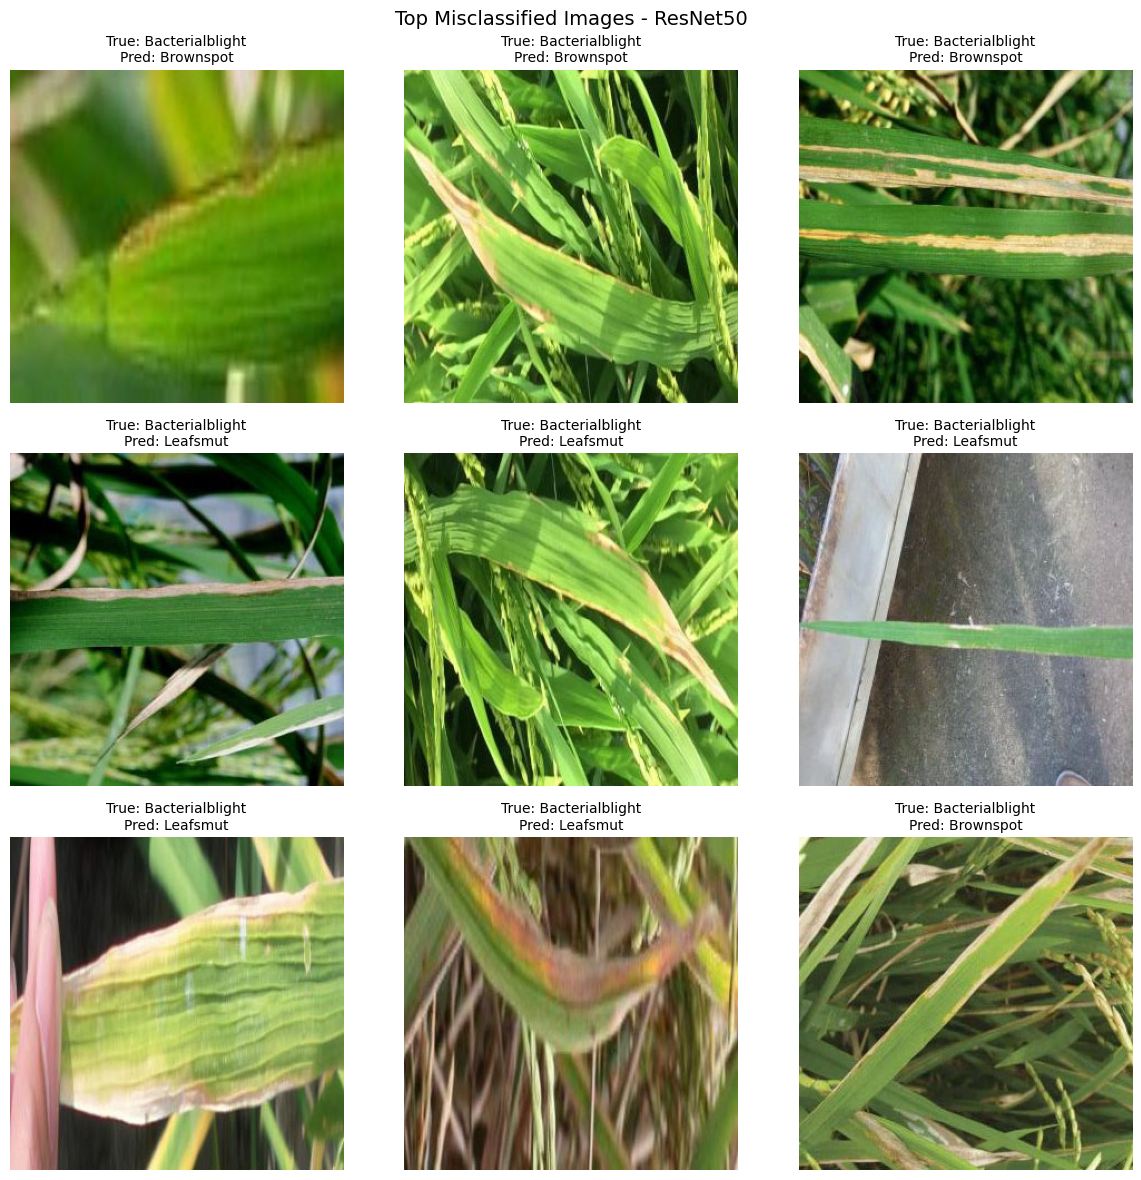

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_val_acc = max(history.history['val_accuracy'])
print(f"✅ Best Validation Accuracy: {best_val_acc:.4f}")


# Predict on validation set
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# 🔹 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50')
plt.tight_layout()
plt.show()

# 🔹 Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 🔹 Misclassified Image Visuals
misclassified_indices = np.where(y_pred != y_true)[0]

if len(misclassified_indices) > 0:
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(misclassified_indices[:9]):
        img_path = val_generator.filepaths[idx]
        img = plt.imread(img_path)
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]

        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)

    plt.suptitle("Top Misclassified Images - ResNet50", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("✅ No misclassifications found in validation set.")
